In [1]:
import sys
sys.path.append('/Ray_finrl/findrl_ray/finenv')
from finenv.env_stocktrading import StockTradingEnv
from finenv.preprocessors import FeatureEngineer, data_split
import pandas as pd
import pickle 
# load the DataFrame from a pickle file
#df = pd.read_pickle('dataset/processed.pkl')

trade = pd.read_csv('./FinRL/examples/trade_data.csv')
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-01-01'
TRADE_START_DATE = '2021-01-02'
TRADE_END_DATE = '2023-03-24'

In [2]:
INDICATORS = ['macd','boll_ub','boll_lb','rsi_30','cci_30','dx_30','close_30_sma','close_60_sma']

In [3]:
import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility

In [4]:
#train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
#trade = data_split(df, TRADE_START_DATE,TRADE_END_DATE)
trade

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2019-05-13,AAL,33.160000,33.200001,31.980000,31.806322,7040900.0,0.0,0.068302,34.569498,32.334916,45.215427,-214.170697,27.605727,33.410860,32.926946,20.549999,66.279113
0,2019-05-13,AAPL,46.927502,47.369999,45.712502,45.109745,229722400.0,0.0,0.197157,51.926067,46.557554,45.444835,-217.008389,36.029204,48.727346,46.152760,20.549999,66.279113
0,2019-05-13,ADBE,270.570007,274.190002,267.220001,267.700012,2698300.0,0.0,1.817067,289.657626,265.629380,49.563237,-70.042576,11.671184,275.212335,267.923668,20.549999,66.279113
0,2019-05-13,ADI,107.139999,107.680000,103.660004,96.640236,4900300.0,0.0,-0.249283,110.952118,99.932762,44.527702,-209.619993,31.042926,104.556207,101.852575,20.549999,66.279113
0,2019-05-13,ADP,158.410004,159.729996,157.000000,144.804428,1898900.0,0.0,0.054466,153.079841,144.267400,51.116730,-122.031963,12.592402,148.526597,144.703038,20.549999,66.279113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,2023-03-29,VRTX,312.549988,316.309998,311.410004,314.239990,1185800.0,2.0,4.272005,316.429879,278.844120,56.805284,201.138085,46.213476,295.763000,299.472166,19.120001,264.841608
977,2023-03-29,WBA,33.980000,34.209999,33.730000,34.150002,6922400.0,2.0,-0.589404,35.703027,31.694973,46.546143,-23.707895,9.421364,34.465000,35.277195,19.120001,264.841608
977,2023-03-29,WDC,35.250000,36.750000,35.250000,36.599998,3704200.0,2.0,-1.045703,38.693062,33.388939,47.458319,-41.506298,1.834005,37.409000,38.855167,19.120001,264.841608


In [5]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 82, State Space: 821


In [6]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [7]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)

In [8]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)
    # specific for trading
    turbulence_threshold = env_config.get('turbulence_threshold', 70)
    risk_indicator_col = env_config.get('risk_indicator_col', 'vix')
    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
        turbulence_threshold=turbulence_threshold,
        risk_indicator_col=risk_indicator_col
    ))

In [9]:
from ray.rllib.agents import ppo
ray.shutdown()

In [10]:
config = ppo.PPOConfig()
config = config.training()
config = config.environment(env_config={'hmax':100, 'initial_amount':1000000})
config = config.framework(framework="torch")
# Rollouts
config = config.rollouts(num_rollout_workers=1,num_envs_per_worker=1,)
# Additional because we are evaluating now
config = config.exploration(explore=False)
config['seed'] = 0
config["model"]["fcnet_hiddens"] = [256, 256, 128]


In [11]:
# registering the environment to ray
register_env("finrl_trading", env_creator_trading)
#trainer = config.build(env="finrl")
# define trainer
trainer = ppo.PPOTrainer(env='finrl_trading', config=config)

2023-04-01 17:52:52,441	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='finrl_trading', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl_trading').build()` instead. This will raise an error in the future!
2023-04-01 17:52:54,500	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
(RolloutWorker pid=70296) 2023-04-01 17:52:58,069	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=70296) 2023-04-01 17:52:58,069	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=70296) /Users/gibson/Downloads/ENTER/lib/python3.9/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN

In [12]:
# load saved agent
#cwd_checkpoint = f"results/checkpoints/ppo_{total_episodes+1}/checkpoint_0000{total_episodes+1}"
#print(f"Restoring from checkpoint {total_episodes+1}")
cwd_checkpoint = 'model/checkpoint_000011'
trainer.restore(cwd_checkpoint)

2023-04-01 17:52:58,183	INFO trainable.py:791 -- Restored on 127.0.0.1 from checkpoint: model/checkpoint_000011
2023-04-01 17:52:58,184	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 11, '_timesteps_total': None, '_time_total': 152.8522732257843, '_episodes_total': 18}


In [13]:
import time 
def DRL_prediction(model, environment):
    start = time.time()
    """make a prediction"""
    state = environment.reset()
    for i in range(len(environment.df.index.unique())):
        action = model.compute_single_action(state)
        state, reward, done, _ = environment.step(action)
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            break
    print("Test Finished!")
    print((time.time()-start),'s')
    return account_memory, actions_memory

In [14]:
df_account_value, df_actions = DRL_prediction(
    model=trainer, 
    environment = e_trade_gym)
df_actions.tail(15)

Test Finished!
9.868366956710815 s


,AAL,AAPL,ADBE,ADI,ADP,ADSK,ALGN,AMAT,AMD,AMGN,...,TXN,UAL,ULTA,VRSK,VRSN,VRTX,WBA,WDC,WYNN,XEL
date,,,,,,,,,,,,,,,,,,,,,
2023-03-08,100,0,0,0,0,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,-42,0
2023-03-09,0,0,0,-46,0,0,0,-61,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-13,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-14
2023-03-14,1,0,0,91,0,0,100,0,0,0,...,0,100,0,0,0,0,0,-54,0,-47
2023-03-15,100,0,0,0,-47,0,0,0,0,0,...,0,-100,0,0,0,0,0,0,0,-64
2023-03-16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-16
2023-03-17,-100,0,0,0,-16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-11
2023-03-20,0,0,0,0,0,0,-100,0,0,0,...,0,0,0,0,0,0,0,0,0,-100


In [15]:
df_actions.sum()

AAL     3164
AAPL       0
ADBE       0
ADI      145
ADP        0
        ... 
VRTX       0
WBA        0
WDC        0
WYNN       0
XEL        0
Length: 82, dtype: int64

In [16]:
import datetime
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

/Users/gibson/Downloads/ENTER/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


==============Get Backtest Results===========
Annual return          0.357842
Cumulative returns     2.277789
Annual volatility      0.281350
Sharpe ratio           1.228547
Calmar ratio           1.387074
Stability              0.861745
Max drawdown          -0.257983
Omega ratio            1.244368
Sortino ratio          1.873429
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.007876
Daily value at risk   -0.034075
dtype: float64


/Users/gibson/Downloads/ENTER/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [17]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (977, 8)
Annual return          0.065560
Cumulative returns     0.279142
Annual volatility      0.229412
Sharpe ratio           0.392497
Calmar ratio           0.176777
Stability              0.542586
Max drawdown          -0.370862
Omega ratio            1.082683
Sortino ratio          0.541938
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.956240
Daily value at risk   -0.028546
dtype: float64


/Users/gibson/Downloads/ENTER/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (977, 8)


/Users/gibson/Downloads/ENTER/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/gibson/Downloads/ENTER/lib/python3.9/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2019-05-13
End date,2023-03-29
Total months,46
,Backtest
Annual return,35.784%
Cumulative returns,227.779%
Annual volatility,28.135%
Sharpe ratio,1.23
Calmar ratio,1.39
Stability,0.86
Max drawdown,-25.798%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.80,2022-04-08,2022-06-14,2022-11-01,148
1,20.02,2020-03-04,2020-03-17,2020-05-06,46
2,19.11,2021-01-20,2021-03-08,2021-07-23,133
3,16.56,2021-09-01,2021-10-12,2022-03-29,150
4,12.45,2020-09-02,2020-09-17,2020-10-13,30


/Users/gibson/Downloads/ENTER/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/gibson/Downloads/ENTER/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/gibson/Downloads/ENTER/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/gibson/Downloads/ENTER/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'fl

Stress Events,mean,min,max
New Normal,0.14%,-8.41%,16.31%


/Users/gibson/Downloads/ENTER/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


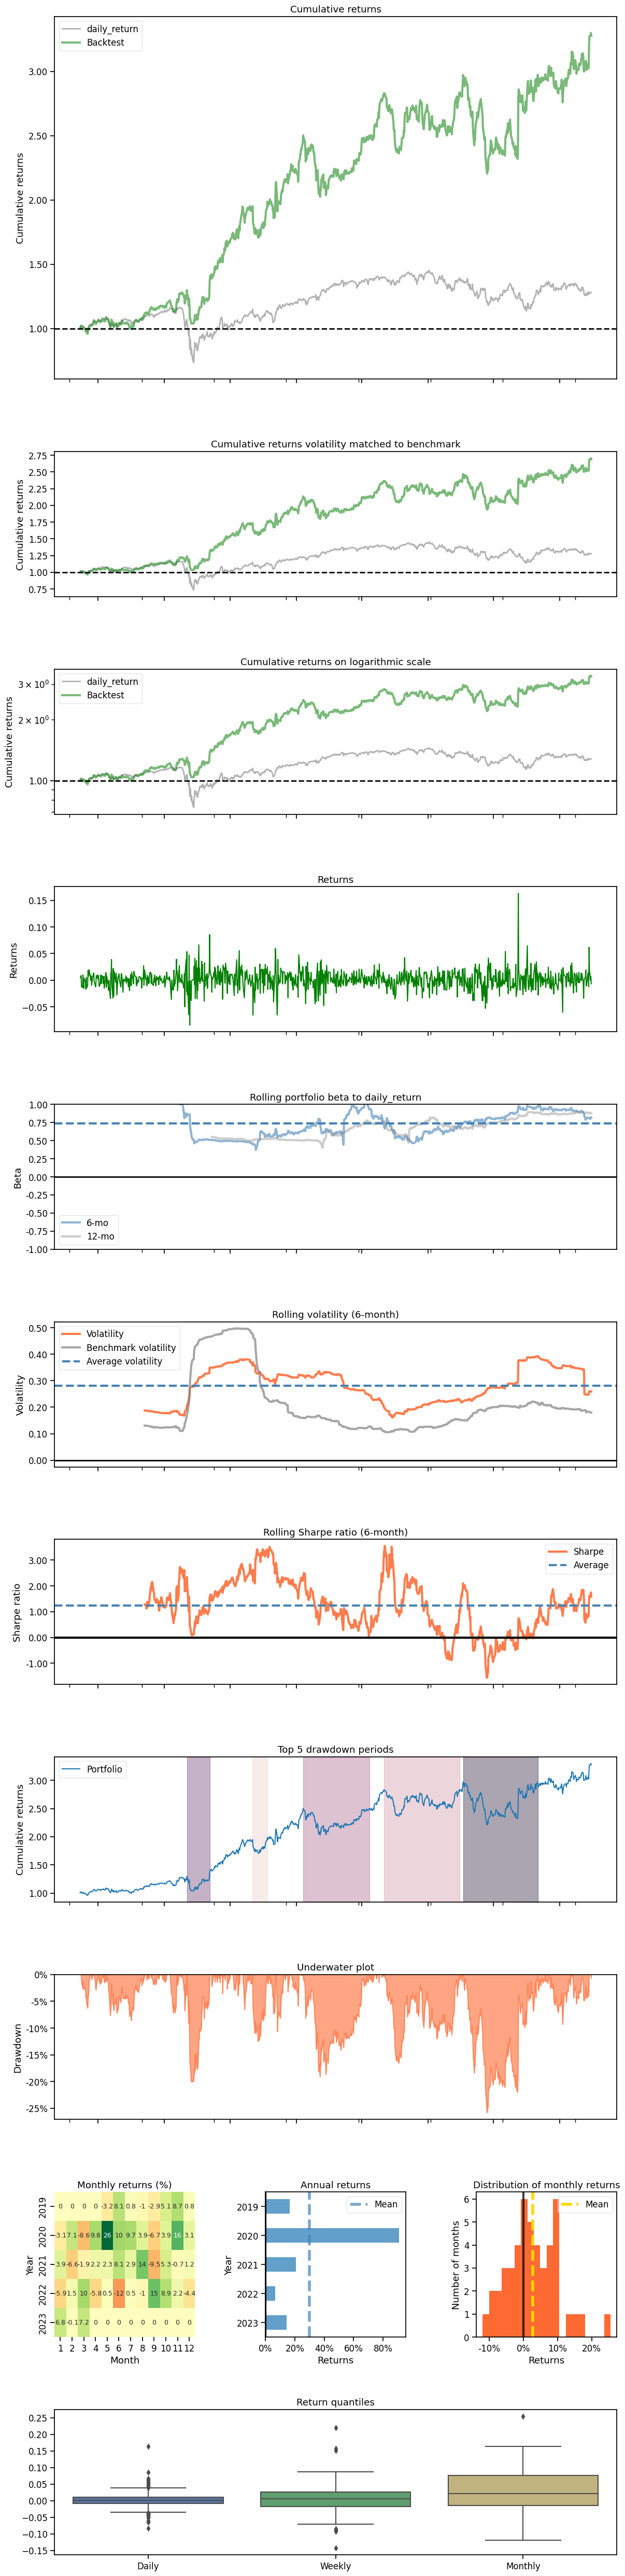

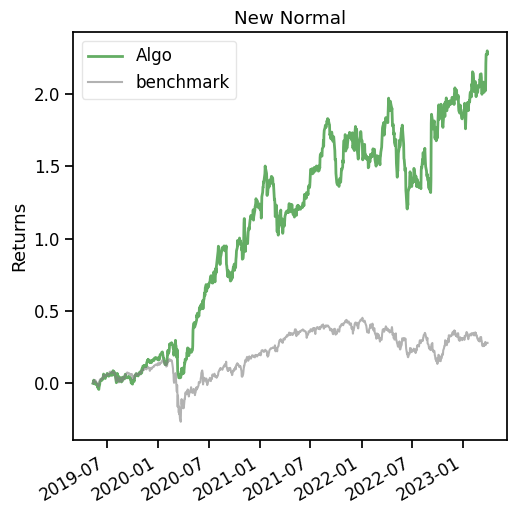

In [18]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])